In [1]:
import os, glob
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2
from torchvision import models
from torch.nn import Conv2d, MaxPool2d
from torch.nn.functional import interpolate
from itertools import chain
import torch

# Step 1: Data Preparation

In [2]:
# crop image for the model input
_crop = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224))
])

# normalize image for model input on which it was trained
_normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def load_images():
    image_files = glob.glob("./samples/*.jpg")
    image_files.sort()

    input_images = [cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) for f in image_files]
    input_batch = torch.stack([_normalize(_crop(image)) for image in input_images])

    return input_batch

# Step 2: Model Loading

In [3]:
from torchvision import models

model_name = 'vgg11'
model = models.get_model(model_name, weights=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Step 3: PRISM Implementation

In [4]:
class TorchPRISM:
    def __init__(self):
        self._excitations = []
        self._hook_handlers = []
        self._is_orig_image = True
        self._variances = None

    def get_variances(self):
        return self._variances

    def _excitation_hook(self, module, input, output):
        # for better output sharpness we collect input images
        if self._is_orig_image:
            self._excitations.append(input[0])
            self._is_orig_image = False

        self._excitations.append(output)

    def register_hooks(self, model, recursive=False):
        if not recursive and self._hook_handlers:
            print("Hooks can only be registered to one model at once. Please use: `prune_old_hooks()`")
            return

        for i, layer in enumerate(model.children()):
            if list(layer.children()):
                self.register_hooks(layer, recursive=True)
            elif isinstance(layer, MaxPool2d):
                self._hook_handlers.append(
                    layer.register_forward_hook(self._excitation_hook)
                )
            elif isinstance(layer, Conv2d) and layer.stride > (1, 1):
                self._hook_handlers.append(
                    layer.register_forward_hook(self._excitation_hook)
                )

    def _get_pc(self, final_excitation):
        final_layer_input = final_excitation.permute(0, 2, 3, 1).reshape(
            -1, final_excitation.shape[1]
        )
        normalized_final_layer_input = final_layer_input - final_layer_input.mean(0)

        u, s, v = normalized_final_layer_input.svd(compute_uv=True)
        self._variances = s**2/sum(s**2) # save the variance
        raw_features = u[:, :3].matmul(s[:3].diag())

        return raw_features.view(
            final_excitation.shape[0],
            final_excitation.shape[2],
            final_excitation.shape[3],
            3
        ).permute(0, 3, 1, 2)

    def _upsampling(self, extracted_features, pre_excitations):
        for e in pre_excitations[::-1]:
            extracted_features = interpolate(
                extracted_features,
                size=(e.shape[2], e.shape[3]),
                mode="bilinear",
                align_corners=False,
            )
            extracted_features *= e.mean(dim=1, keepdim=True)
        return extracted_features

    def _normalize_to_rgb(self, features):
        scaled_features = (features - features.mean()) / features.std()
        scaled_features = scaled_features.clip(-1, 1)
        scaled_features = (scaled_features - scaled_features.min()) / (
            scaled_features.max() - scaled_features.min()
        )
        return scaled_features

    def prism(self, grad_extrap=True):
        if not self._excitations:
            print("No data in hooks. Have You used `register_hooks(model)` method?")
            return

        with torch.no_grad():
            rgb_features_map = self._get_pc(self._excitations.pop())

            if grad_extrap:
                rgb_features_map = self._upsampling(
                    rgb_features_map, self._excitations
                )
            rgb_features_map = self._normalize_to_rgb(rgb_features_map)

        # prune old self._excitations
        self.reset_excitations()

        return rgb_features_map

    def reset_excitations(self):
        self._is_orig_image = True
        self._excitations = []

In [5]:
# additional functions
def _normalize_image(image):
    # change image tensor from -1,1 to 0,1
    return (image - image.min()) / (image.max() - image.min())

# function to visualize input and output images.
def draw_input_n_prism(drawable_input_batch, drawable_prism_maps_batch):
    columns = drawable_input_batch.shape[0]
    fig, ax = plt.subplots(nrows=columns, ncols=2)
    if columns == 1:
        ax[0].imshow(_normalize_image(drawable_input_batch[0]))
        ax[0].axis('off')
        ax[1].imshow(drawable_prism_maps_batch[0])
        ax[1].axis('off')
    else:
        for column in range(columns):
            ax[column][0].imshow(_normalize_image(drawable_input_batch[column]))
            ax[column][0].axis('off')

        for column in range(columns):
            ax[column][1].imshow(drawable_prism_maps_batch[column])
            ax[column][1].axis('off')

    fig.tight_layout()
    plt.savefig(f"PRISM_result.png", format='png', bbox_inches="tight", dpi=500)

# How to use different models

## VGG11

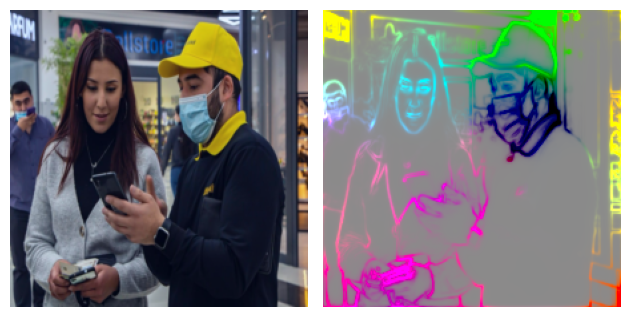

In [6]:
# load images into batch
input_batch = load_images()
prism = TorchPRISM()

model = models.vgg11(weights=True).eval()
prism.register_hooks(model)

model(input_batch)

prism_maps_batch = prism.prism()

drawable_input_batch = input_batch.permute(0, 2, 3, 1).detach().cpu().numpy()
drawable_prism_maps_batch = prism_maps_batch.permute(0, 2, 3, 1).detach().cpu().numpy()

draw_input_n_prism(drawable_input_batch, drawable_prism_maps_batch)

## ResNet101

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


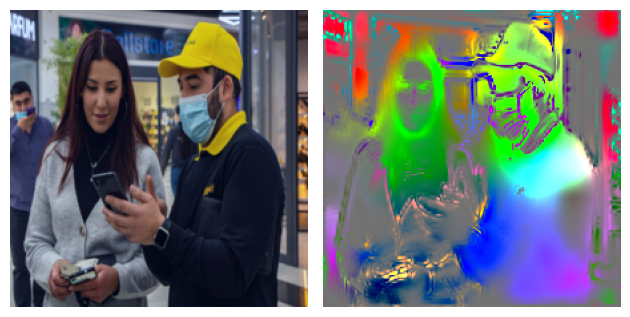

In [7]:
# load images into batch
input_batch = load_images()
prism = TorchPRISM()

model = models.resnet101(weights=True).eval()
prism.register_hooks(model)

model(input_batch)

prism_maps_batch = prism.prism()

drawable_input_batch = input_batch.permute(0, 2, 3, 1).detach().cpu().numpy()
drawable_prism_maps_batch = prism_maps_batch.permute(0, 2, 3, 1).detach().cpu().numpy()

draw_input_n_prism(drawable_input_batch, drawable_prism_maps_batch)

## GoogleNet

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


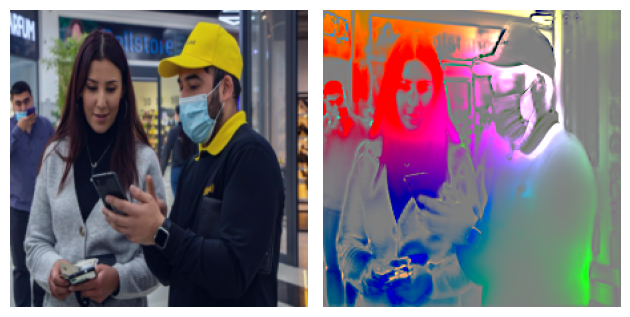

In [8]:
# load images into batch
input_batch = load_images()
prism = TorchPRISM()

model = models.googlenet(weights=True).eval()
prism.register_hooks(model)

model(input_batch)

prism_maps_batch = prism.prism()

drawable_input_batch = input_batch.permute(0, 2, 3, 1).detach().cpu().numpy()
drawable_prism_maps_batch = prism_maps_batch.permute(0, 2, 3, 1).detach().cpu().numpy()

draw_input_n_prism(drawable_input_batch, drawable_prism_maps_batch)